In [1]:
import xarray as xr
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt

### load in the forecast data, create temperature time series

We know that the evolution of forecasts from numerical weather prediction is sensitive to the models initial conditions. Ensemble sensitivity analysis tries to identify patterns in the Atmosphere that a forecast value may sensitive to, using simple linear regression. We are extending this principle to say "changes in the 1 - 5 will effect the 6 - 10". If we could prove this successful with back-testing, this could be used to automatically trade model deltas. We would need to better understand if such trades have enough liquidity to be worthwhile. 

In the interest of time and computing power, I have kept this to just be a simple linear regression, but in practice we would probably go down a different path (RLM, NNet, etc.). I am looking to see if changes in NH 500mb pressure patterns the 1 - 5 can be used to predict the next (06Z) runs changes in 6-10 US CDDs. 

*Issues* 
- We are assuming the ensemble is well calibrated and captures all possibilities, which it is not
- n=21 in the regression
- Using the entire northern hemisphere, when most of it is probably not relevant
- Obviously, we can't actually say what is presented here is meaningful

*A better way to do this*
- autocorrelate CDDs with 500-hPa patterns to better tune gridpoints used in regression and filter out the noise
- autocorrelate with 500-hPa EOFs to try and filter out some noise
- filter out non-significant gridpoints
- Try this on a larger multimodel ensemble, perhaps use the last 4 runs to increase training size
- Add more features than just H500

In [2]:
# Training forecast
fcst1=xr.open_dataset(
    'http://thredds-jetstream.unidata.ucar.edu/thredds/dodsC/grib/NCEP/GEFS/Global_1p0deg_Ensemble/members/GEFS_Global_1p0deg_Ensemble_20200527_0000.grib2',
    chunks={'ens': 21}
)
cdds=pd.read_csv('gfs-ens-cdds_20200527.csv')
cdds00=cdds[cdds.run=='gfs-ens-00z'].cdds.values.reshape(65,21)[1::4] # shift 6H to align with gfs-ens-06z
cdds06=cdds[cdds.run=='gfs-ens-06z'].cdds.values.reshape(65,21)[::4]

# H500 for sensitivity
h500=fcst1.Geopotential_height_isobaric_ens.sel(isobaric3=50000,lat=slice(90,0)).resample(time='D').mean().compute()

# Forecast 2
fcst2=xr.open_dataset(
    'http://thredds-jetstream.unidata.ucar.edu/thredds/dodsC/grib/NCEP/GEFS/Global_1p0deg_Ensemble/members/GEFS_Global_1p0deg_Ensemble_20200527_0600.grib2',
    chunks={'ens': 21}
)
h500_2=fcst2.Geopotential_height_isobaric_ens.sel(isobaric3=50000,lat=slice(90,0)).resample(time='D').mean().compute()

# # estimate temperature over population centers 
# tmp_mwe=fcst1.Temperature_height_above_ground_ens.sel(
#     lat=slice(42.2,32.2),
#     lon=slice(360-88.9,360-73.2)
# ).squeeze()

# # cos weight latitude
# cosweight=np.tile(
#     np.sqrt(
#         np.cos(
#             np.deg2rad(
#                 tmp_mwe.lat.values
#             )
#         )
#     ).reshape(1,-1),(tmp_mwe.shape[0],tmp_mwe.shape[1],tmp_mwe.shape[3],1)).transpose(0,1,3,2)

# resample to daily
# tmp_mwe=(tmp_mwe*cosweight).mean(['lat','lon']).resample(time='D').mean()

In [5]:
X=sm.add_constant(h500.isel(time=slice(1,4)).mean('time').values.reshape(21,91*360))
Y=cdds00[5:9,:].sum(axis=0)
mdl=sm.OLS(Y,X).fit()

Xpred=sm.add_constant(h500_2.isel(time=slice(1,4)).mean('time').values.reshape(21,91*360))
new_dist=mdl.predict(Xpred)

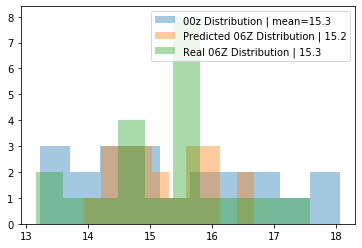

In [10]:
Yreal=cdds06[5:9,:].sum(axis=0)

fig,ax=plt.subplots()
ax.hist(Y,label=f'00z Distribution | mean={Y.mean():0.1f}',alpha=0.4)
ax.hist(new_dist,label=f'Predicted 06Z Distribution | {new_dist.mean():0.1f}',alpha=0.4)
ax.hist(Yreal,label=f'Real 06Z Distribution | {Yreal.mean():0.1f}',alpha=0.4)
ax.legend()